# Tidal Power Performance Analysis

The following example demonstrates a simple workflow for conducting the power performance analysis of a turbine, given turbine specifications, power data, and Acoustic Doppler Current Profiler (ADCP) water measurements.

In this case, the turbine specifications can be broken down into
  1. Shape of the rotor's swept area
  2. Turbine rotor diameter/height and width
  3. Turbine hub height (center of swept area)

Additional data needed:
  - Power data from the current energy converter (CEC)
  - 2-dimensional water velocity data

In this jupyter notebook, we'll be covering the following three topics:
  1. CEC power-curve
  2. Velocity profiles
  3. CEC efficiency profile (or power coefficient profile)

Start by importing the necessary tools:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mhkit.tidal import performance
from mhkit.dolfyn import load

In this case, we'll use ADCP data from the ADCP example notebook. I am importing a dataset from the ADCP example notebook. This data retains the original timestamps (1 Hz sampling frequency) and was rotated into the principal coordinate frame (streamwise-cross_stream-up).

In [2]:
# Open processed ADCP dataset
ds = load('data/tidal/adcp.principal.a1.20200815.nc')

Next, since we don't have power data, we'll invent a mock timeseries based off the cube of water velocity, just to have something to work with.

In [3]:
# Streamwise and hub-height water velocity
streamwise_vel = ds['vel'].sel(dir='streamwise')
hub_height_vel = abs(streamwise_vel.isel(range=10))

# Emulate power data
power = hub_height_vel**3 * 1e5
# Emulate cut-in speed by setting power at flow speeds below 0.5 m/s to 0 W
power = power.where(abs(streamwise_vel.mean('range')) > 0.5, 0)

The first step for any of the following calculations is to first split velocity into ebb and flood tide. You'll need some background information on the site to know which direction is positive and which is negative in the data.

In [4]:
ebb = streamwise_vel.where(streamwise_vel > 0)
flood = streamwise_vel.where(streamwise_vel < 0)

With the ebb and flood velocities, we can also divide the power data into that for ebb and flood tides.

In [5]:
# Make sure ebb and flood are on same timestamps
power = power.interp(time=streamwise_vel['time'])

power_ebb = power.where(~ebb.mean('range').isnull(), 0)
power_flood = power.where(~flood.mean('range').isnull(), 0)

### Power-curve

Now with power and velocity divided into ebb and flood tides, we can calculate the power curve for the CEC in both conditions


In [6]:
power_curve_ebb = performance.power_curve(
    power_ebb,
    velocity=ebb,
    hub_height=4.2,
    doppler_cell_size=0.5, 
    sampling_frequency=1, 
    window_avg_time=600,
    turbine_profile='circular',
    diameter=3,
    height=None,
    width=None)
power_curve_flood = performance.power_curve(
    power_flood,
    velocity=flood,
    hub_height=4.2,
    doppler_cell_size=0.5, 
    sampling_frequency=1, 
    window_avg_time=600,
    turbine_profile='circular',
    diameter=3,
    height=None,
    width=None)

In [7]:
power_curve_flood

,U_avg,U_avg_power_weighted,P_avg,P_std,P_max,P_min
U_bins,,,,,,
"(0.0, 0.1]",0.067459,0.000000,0.000000,0.000000,0.000000,0.000000
"(0.1, 0.2]",0.115614,0.000000,0.000000,0.000000,0.000000,0.000000
"(0.2, 0.3]",0.249676,0.225639,0.000000,0.000000,0.000000,0.000000
"(0.3, 0.4]",0.339600,0.315561,0.000000,0.000000,0.000000,0.000000
"(0.4, 0.5]",0.459393,0.437249,2890.724986,2660.810022,5551.535008,229.914964
"(0.5, 0.6]",0.548507,0.532974,19677.343518,4645.890936,24323.234454,15031.452582
"(0.6, 0.7]",0.671449,0.655362,40369.435517,3679.260135,45506.306677,37083.470337
"(0.7, 0.8]",0.726189,0.704845,52413.972024,2856.737142,57360.861473,50670.102583
"(0.8, 0.9]",0.843958,0.825916,79944.000855,9798.569674,96206.928025,66531.815452


Next we can plot the two power curves. A velocity bin is missing in the ebb tide power curve in this example because the data is so short, there are no samples for that bin.

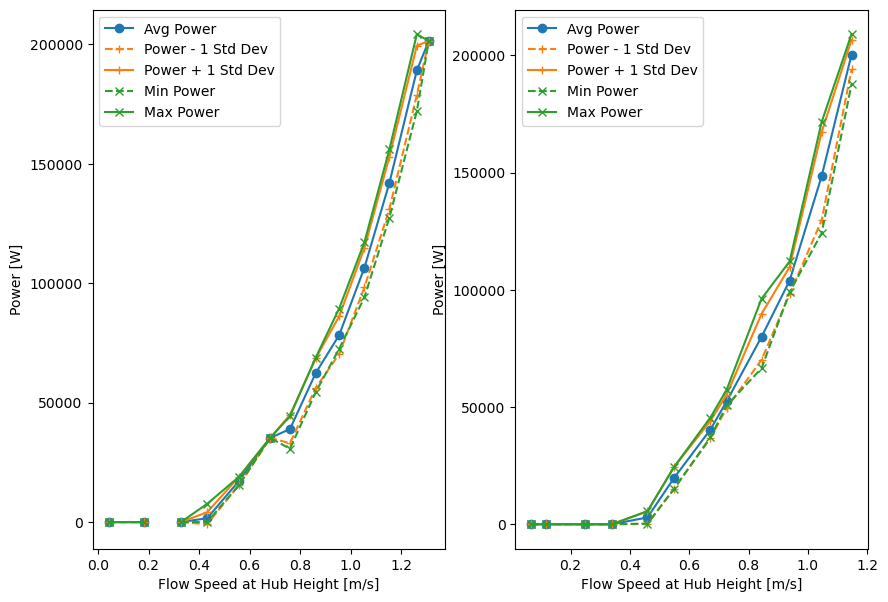

In [8]:
def plot_power_curve(P_curve, ax):
    ax.plot(P_curve['U_avg'], P_curve['P_avg'], '-o', color='C0', label='Avg Power')
    ax.plot(P_curve['U_avg'], (P_curve['P_avg'] - P_curve['P_std']), '--+', color='C1', label='Power - 1 Std Dev')
    ax.plot(P_curve['U_avg'], (P_curve['P_avg'] + P_curve['P_std']), '-+', color='C1', label='Power + 1 Std Dev')
    ax.plot(P_curve['U_avg'], P_curve['P_min'], '--x', color='C2', label='Min Power')
    ax.plot(P_curve['U_avg'], P_curve['P_max'], '-x', color='C2', label='Max Power')
    ax.set(xlabel='Flow Speed at Hub Height [m/s]', ylabel='Power [W]')
    ax.legend()

fig, ax = plt.subplots(1,2, figsize=(10,7))
plot_power_curve(power_curve_ebb, ax[0])
plot_power_curve(power_curve_flood, ax[1])

### Velocity Profiles
Various velocity profiles can be created next from the water velocity data, and we can do this again with ebb and flood tide. These functions are following three steps:
  1. Reshape the data into bins by time (ensembles)
  2. Apply a function to the ensembles to get ensemble statistics (mean, root-mean-square (RMS), or standard devation)
  3. Regroup and bin the ensemble statistics by flow speed

These profiles are created using the `velocity_profiles` method, and a profile is specified using the "function" argument. For the average velocity profiles, we'll set the function = 'mean'.


In [9]:
avg_profile_ebb = performance.velocity_profiles(
    velocity=ebb, 
    hub_height=4.2,
    sampling_frequency=1, 
    window_avg_time=600,
    function='mean')
avg_profile_flood = performance.velocity_profiles(
    velocity=ebb, 
    hub_height=4.2,
    sampling_frequency=1, 
    window_avg_time=600,
    function='mean')


### RMS Tidal Velocity

For RMS velocity profiles, we'll set the function = 'rms'.

In [10]:
rms_profile_ebb = performance.velocity_profiles(
    velocity=ebb, 
    hub_height=4.2,
    sampling_frequency=1, 
    window_avg_time=600,
    function='rms')
rms_profile_flood = performance.velocity_profiles(
    velocity=ebb, 
    hub_height=4.2,
    sampling_frequency=1, 
    window_avg_time=600,
    function='rms')

### Std Dev Tidal Velocity

And to get the standard deviation, we'll set function = 'std'.

In [11]:
std_profile_ebb = performance.velocity_profiles(
    velocity=ebb, 
    hub_height=4.2,
    sampling_frequency=1, 
    window_avg_time=600,
    function='std')
std_profile_flood = performance.velocity_profiles(
    velocity=ebb, 
    hub_height=4.2,
    sampling_frequency=1, 
    window_avg_time=600,
    function='std')

Finally, we can plot these variables together based on ebb and flood tides. The following code plots the mean and RMS profiles as line plots with "x" and "+" markers, respectively, and shades the area between +/- 1 standard deviation from the mean.

Text(0.5, 1.0, 'Flood Tide')

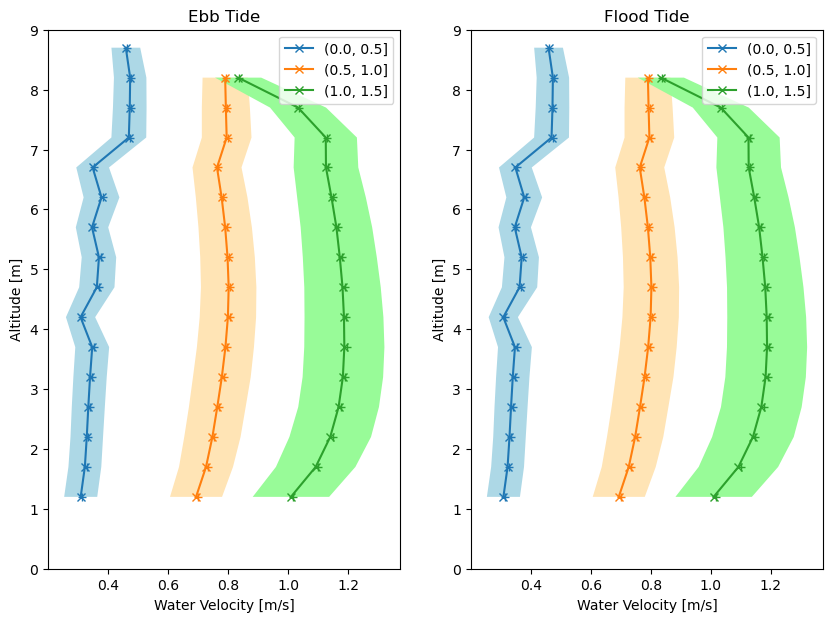

In [12]:
def plot_velocity_profiles(avg_profile, rms_profile, std_profile, ax):
    alt = avg_profile.index
    mean = avg_profile.values.T
    rms = rms_profile.values.T
    std = std_profile.values.T

    ax.plot(mean[0], alt, '-x', label=avg_profile.columns[0])
    ax.plot(mean[1], alt, '-x', label=avg_profile.columns[1])
    ax.plot(mean[2], alt, '-x', label=avg_profile.columns[2])

    ax.fill_betweenx(alt, mean[0]-std[0], mean[0]+std[0], facecolor='lightblue')
    ax.fill_betweenx(alt, mean[1]-std[1], mean[1]+std[1], facecolor='moccasin')
    ax.fill_betweenx(alt, mean[2]-std[2], mean[2]+std[2], facecolor='palegreen')

    ax.plot(rms[0], alt, '+', color='C0')
    ax.plot(rms[1], alt, '+', color='C1')
    ax.plot(rms[2], alt, '+', color='C2')
    ax.set(xlabel='Water Velocity [m/s]', ylabel='Altitude [m]', ylim=(0,9))
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
plot_velocity_profiles(avg_profile_ebb, rms_profile_ebb, std_profile_ebb, ax[0])
ax[0].set_title('Ebb Tide')
plot_velocity_profiles(avg_profile_flood, rms_profile_flood, std_profile_flood, ax[1])
ax[1].set_title('Flood Tide')

### Current Energy Converter Efficiency

The CEC efficiency, or device power coefficient, can be found using the `device_efficiency` method.

In [13]:
efficiency_ebb = performance.device_efficiency(
    power=power_ebb,
    velocity=ebb,
    water_density=ds['water_density'],
    capture_area=np.pi*1.5**2,
    hub_height=4.2,
    sampling_frequency=1,
    window_avg_time=600)
efficiency_flood = performance.device_efficiency(
    power=power_flood,
    velocity=flood,
    water_density=ds['water_density'],
    capture_area=np.pi*1.5**2,
    hub_height=4.2,
    sampling_frequency=1,
    window_avg_time=600)

And these efficiency curves can be plotted as profiles:

Text(0.5, 1.0, 'Flood Tide')

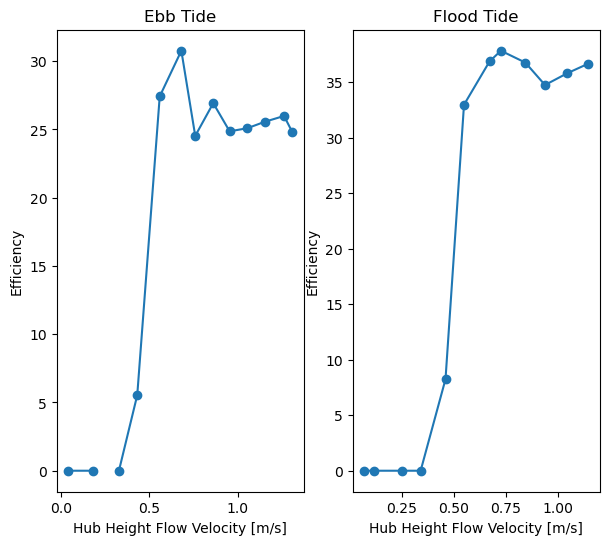

In [14]:
def plot_efficiency(efficiency, ax):
    means = efficiency.U_avg.values.T
    eta = efficiency.Efficiency.values.T
    ax.plot(means, eta, '-o')
    ax.set(xlabel="Hub Height Flow Velocity [m/s]", ylabel='Efficiency')

fig, ax = plt.subplots(1, 2, figsize=(7, 6))
plot_efficiency(efficiency_ebb, ax[0])
ax[0].set_title('Ebb Tide')
plot_efficiency(efficiency_flood, ax[1])
ax[1].set_title('Flood Tide')